# Пробуем уменьшить th принятия решения

In [1]:
import os
import re
import pickle
import json
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from collections import defaultdict
from hack_lap.utils.evaluate import precision_recall, estimate_prediction, calculate_metrics_one_vs_rest_

In [2]:
import matplotlib
# matplotlib.use('Qt5Agg')
# %matplotlib qt5
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
DIR_DATA = os.path.join('..', 'data')
DIR_PREDICT = os.path.join(DIR_DATA, 'predict') 
DIR_MODEL = os.path.join(DIR_DATA, 'model')
MIN_F1 = 0.30

ps = re.compile(f'seed-(\d+)', re.I)
pr = re.compile(f'r-(\d+)', re.I)

files_json = [n for n in os.listdir(DIR_MODEL) if n.endswith('.json') and n.startswith('b') and 'best' in n]

files_by_try = defaultdict(list)
for f in files_json:
    seed = [int(g.group(1)) for g in ps.finditer(f)]
    r = [int(g.group(1)) for g in pr.finditer(f)]
    assert len(seed) == 1
    assert len(r) == 1
    seed = seed[0]
    r = r[0]
    files_by_try[(seed, r)].append(f)
    
files_json = []
for _, v in files_by_try.items():
    best_v = None
    best_f1 = 0.0
    for vi in v:
        with open(os.path.join(DIR_MODEL, vi)) as fp:
            res = json.load(fp)
        if best_f1 < res['best_f1']:
            best_f1 = res['best_f1']
            best_v = vi
    if best_f1 < MIN_F1:
        continue
    files_json.append((best_v, best_f1))
len(files_json)

38

In [5]:
f_json, f1 = files_json[30]
f = f_json.replace('json', 'pkl')
with open(os.path.join(DIR_MODEL, f), 'rb') as fp:
    data = pickle.load(fp)
yt_dev, yp_dev, yp_test = data['yt_dev'], data['yp_dev'], data['yp_test']


In [6]:
calculate_metrics_one_vs_rest_(yt_dev, yp_dev, dump_factor=1.0, cls_count_0=5000, cls_count_1=200)

((0.9741932116778383, 0.9872944693572496, 0.9806995872821974),
 (0.5214793001905421, 0.34615384615384615, 0.4161018009978643))

In [8]:
calculate_metrics_one_vs_rest_(yt_dev, yp_dev, dump_factor=0.99, cls_count_0=1600, cls_count_1=30)

((0.9880735155910815, 0.9857997010463379, 0.9869347986527897),
 (0.32544186800713526, 0.36538461538461536, 0.3442580228221935))

  0%|          | 0/31 [00:00<?, ?it/s]

(0.3442580228221935, 0.9933333333333334)

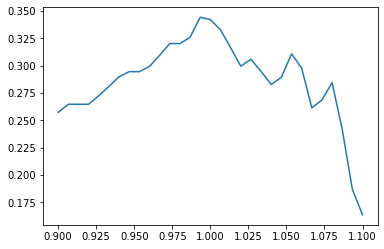

In [10]:
x = np.linspace(0.9, 1.1, 31)
s = []
for f in tqdm(x):
    _, (_, _, a) = calculate_metrics_one_vs_rest_(yt_dev, yp_dev, dump_factor=f, cls_count_0=1600, cls_count_1=30)
    s.append(a)
    
plt.plot(x, s);

ii = np.nanargmax(s)
s[ii], x[ii]